# Feature Selection

## Imports and preprocessing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import arviz as az
import pymc as pm
from zipfile import ZipFile
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay, auc, roc_curve
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.impute import SimpleImputer

In [2]:
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)

In [3]:
# read in data
zip_file = ZipFile("data/adult23csv.zip")

df_full = pd.read_csv(zip_file.open('adult23.csv'))
y_name = 'LONGCOVD1_A'


In [4]:
from preprocessing_clean import preprocess_all_columns

X_train, X_test, y_train, y_test = preprocess_all_columns(df_full)

## CHI-SQUARED FEATURE SELECTION

SCORES ABOVE 50:
Feature FDSCAT4_A_4.0: 134.15588975950797
Feature FDSCAT3_A_3.0: 134.15588975950797
Feature EMERG12MTC_A_4.0: 57.83366063803564
Feature FDSBALANCE_A_2.0: 65.4390447876636
Feature FDSLAST_A_2.0: 72.47892204568376
Feature FDSRUNOUT_A_2.0: 73.15557801784396
Feature BALDIZZ_A_2.0: 68.3533284009751
Feature PAITOOTH3M_A_3.0: 60.32857783762549
Feature PAITOOTH3M_A_101.0: 86.26780959428157
Feature PAIAPG3M_A_3.0: 61.38000434640243
Feature PAIAPG3M_A_101.0: 86.26780959428157
Feature PAIHDFC3M_A_3.0: 163.0427651121782
Feature PAIHDFC3M_A_101.0: 86.26780959428157
Feature PAILLMB3M_A_3.0: 134.63851978253703
Feature PAILLMB3M_A_101.0: 86.26780959428157
Feature PAIULMB3M_A_3.0: 181.59409352242733
Feature PAIULMB3M_A_101.0: 86.26780959428157
Feature PAIBACK3M_A_3.0: 117.88611120031949
Feature PAIBACK3M_A_101.0: 86.26780959428157
Feature PAIAFFM3M_A_2.0: 121.20076329350452
Feature PAIAFFM3M_A_101.0: 86.26780959428157
Feature PAIWKLM3M_A_2.0: 77.32130009735788
Feature PAIWKLM3M_A_3.0: 

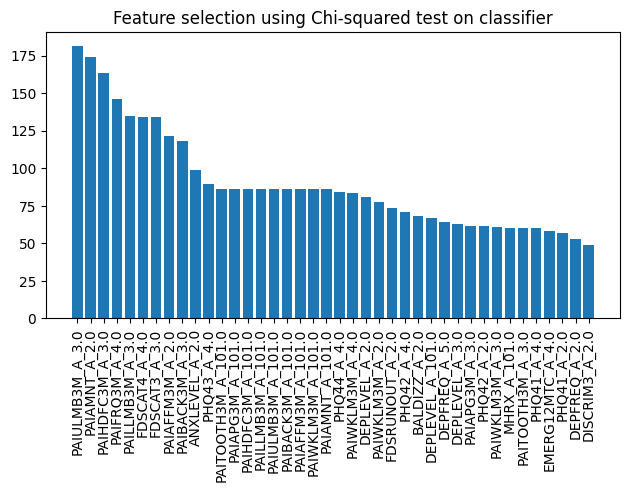

In [5]:
# feature selection
def select_features(X_train, y_train, X_test):
    # perform an imputation to handle missingness
    imputer = SimpleImputer(strategy="constant", fill_value=101)
    X_train_imputed = imputer.fit_transform(X_train)
    X_test_imputed = imputer.fit_transform(X_test)

    fs = SelectKBest(score_func=chi2, k='all')
    fs.fit(X_train_imputed, y_train)
    X_train_fs = fs.transform(X_train_imputed)
    X_test_fs = fs.transform(X_test_imputed)
    return X_train_fs, X_test_fs, fs


def print_top_k_scores(X_train, fs, k=10):
    # what are scores for the features
    print(f"SCORES ABOVE {k}:")
    feats = []
    for i, feat in enumerate(X_train.columns):
        if fs.scores_[i] > k:
            print(f'Feature {feat}: {fs.scores_[i]}')
            feats.append(feat)
    return feats


def plot_feature_scores(X_train, fs):
    topfeats = sorted(zip(X_train.columns,fs.scores_), key=lambda x:x[1], reverse=True)[:40]
    names = [feat[0] for feat in topfeats]
    scores = [feat[1] for feat in topfeats]
    # plot the scores
    fig, ax = plt.subplots()
    # ax.bar(list(X_train.columns), fs.scores_, label=list(X_train.columns))
    ax.bar(names, scores, label=names)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.title("Feature selection using Chi-squared test on classifier")
    plt.show()

# feature selection
X_train, X_test, y_train, y_test = preprocess_all_columns(df_full)
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test)
feats = print_top_k_scores(X_train, fs, k=50)
plot_feature_scores(X_train, fs)

In [6]:
topfeats = sorted(zip(X_train.columns,fs.scores_), key=lambda x:x[1], reverse=True)[:40]

In [7]:
list(set([re.search('(.+)_\d+\.0',feat[0]).group(1) for feat in topfeats]))

['PHQ42_A',
 'PHQ41_A',
 'PAIHDFC3M_A',
 'PAITOOTH3M_A',
 'BALDIZZ_A',
 'FDSCAT3_A',
 'EMERG12MTC_A',
 'PHQ43_A',
 'MHRX_A',
 'PHQ44_A',
 'DEPFREQ_A',
 'PAIAPG3M_A',
 'PAIULMB3M_A',
 'FDSCAT4_A',
 'PAIAMNT_A',
 'PAILLMB3M_A',
 'PAIAFFM3M_A',
 'ANXLEVEL_A',
 'PAIFRQ3M_A',
 'PAIWKLM3M_A',
 'DISCRIM3_A',
 'FDSRUNOUT_A',
 'PAIBACK3M_A',
 'DEPLEVEL_A']

In [8]:
from collections import Counter
Counter([re.search('(.+)_\d+\.0',feat[0]).group(1) for feat in topfeats])

Counter({'PAIWKLM3M_A': 4,
         'DEPLEVEL_A': 3,
         'PAIULMB3M_A': 2,
         'PAIAMNT_A': 2,
         'PAIHDFC3M_A': 2,
         'PAILLMB3M_A': 2,
         'PAIAFFM3M_A': 2,
         'PAIBACK3M_A': 2,
         'PAITOOTH3M_A': 2,
         'PAIAPG3M_A': 2,
         'PHQ42_A': 2,
         'DEPFREQ_A': 2,
         'PHQ41_A': 2,
         'PAIFRQ3M_A': 1,
         'FDSCAT4_A': 1,
         'FDSCAT3_A': 1,
         'ANXLEVEL_A': 1,
         'PHQ43_A': 1,
         'PHQ44_A': 1,
         'FDSRUNOUT_A': 1,
         'BALDIZZ_A': 1,
         'MHRX_A': 1,
         'EMERG12MTC_A': 1,
         'DISCRIM3_A': 1})

- 'MHRX_A', : Took medication for other emotions/concentration/behavior/mental health, past 12 months ***
- 'PAILLMB3M_A', : Pain in hips
-'PAIULMB3M_A', : Pain in hands
- 'FDSCAT3_A', : Adult 3 category food security recode  *** 
- 'ANXLEVEL_A', : Level of feelings when last felt worried/nervous/anxious ***
- 'PAIWKLM3M_A', : How often pain limits life or work ***
- 'EMERG12MTC_A', : Number of times visited hospital emergency room, past 12 months, top-coded ***
- 'DISCRIM3_A', :  Treated as not smart ***
- 'PHQ43_A', : How often felt nervous/anxious/on edge, past 2 weeks
- 'PHQ44_A', :  How often can't stop/control worrying, past 2 weeks
- 'PAIBACK3M_A', : Back pain
- 'PHQ41_A', : How often little interest in things, past 2 weeks
- 'FDSCAT4_A', : Adult 4 category food security recode 
- 'FDSRUNOUT_A', : Worry food would run out
- 'BALDIZZ_A', : Balance or dizziness problem past 12 months *** 
- 'PAIAMNT_A', : How much pain last time
- 'PAIFRQ3M_A', : How often had pain, past 3 months
- 'PHQ42_A', : How often feeling down, past 2 weeks
- 'PAIAPG3M_A', : Abdominal pain
- 'DEPFREQ_A', : How often depressed
- 'PAITOOTH3M_A', : Toothache or jaw pain
- 'DEPLEVEL_A', : Level of how depressed ***
- 'PAIAFFM3M_A', : How often pain impacts family
 -'PAIHDFC3M_A' : Migraine

## HORSESHOE PRIOR

In [9]:
X_train.shape

(11944, 1322)

In [10]:
# N, D = X_train.shape

# coords = {"predictors" : X_train.columns.values}

# # IT IS INTRACTIBLE TO RUN IT THIS WAY
# with pm.Model(coords=coords) as sparse_model:
#     X = X_train.values
#     lamda = pm.HalfCauchy('lambda', beta=1, dims="predictors")
#     tau = pm.HalfCauchy('tau', beta=1)
#     sigma = pm.Deterministic('horseshoe', tau*tau*lamda*lamda)
#     beta = pm.Normal('beta', mu=0, sigma=sigma, dims="predictors")
#     beta0 = pm.Normal('beta0', mu=0, sigma=10)
#     mu = pm.math.invlogit(pm.math.dot(X, beta) + beta0)
#     y = pm.Bernoulli('obs', p=mu, observed=y_train.values)
# sparse_model


## SPARSITY ENFORCING PRIOR: https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html
import pytensor.tensor as pt

N, D = X_train.shape
D0 = 10 # guess at the true number of predictors


with pm.Model(coords={"predictors": X_train.columns.values}) as sparse_model:
    x = X_train.values
    
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 10)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 4, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    betas = pm.Deterministic(
        "beta", z * tau * lam * pt.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    b0 = pm.Normal("beta0", 0, 100)

    # Model
    logitp = b0 + pm.math.dot(x, betas)
    theta = 1 / (1 + pm.math.exp(-logitp))
    y = pm.Bernoulli('y', p=theta, observed=y_train.values)

sparse_model

sigma ~ HalfNormal(0, 10)
  tau ~ HalfStudentT(2, f(sigma))
  lam ~ HalfStudentT(4, 1)
   c2 ~ InverseGamma(1, 1)
    z ~ Normal(0, 1)
beta0 ~ Normal(0, 100)
 beta ~ Deterministic(f(lam, z, c2, tau))
    y ~ Bernoulli(f(beta0, lam, z, c2, tau))

In [11]:
print(f"df_full shape: {df_full.shape}")
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")

df_full shape: (29522, 647)
X_train shape: (11944, 1322), y_train shape: (11944,)


In [12]:
with sparse_model:
    idata_sparse = pm.sample(500, tune=1000, chains=2, target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Output()

Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3435 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [13]:
summary = az.summary(idata_sparse, var_names=["beta"], hdi_prob=0.95)
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[PPSU],0.052,0.082,-0.057,0.250,0.003,0.002,643.0,784.0,1.00
beta[PSTRAT],-0.017,0.044,-0.128,0.057,0.001,0.001,1008.0,960.0,1.00
beta[SPOUSAGETC_A],0.002,0.054,-0.101,0.129,0.002,0.001,873.0,874.0,1.01
beta[EMPDYSMSS3_A],-0.007,0.065,-0.153,0.127,0.002,0.002,928.0,777.0,1.00
beta[EMPWKHRS3_A],0.009,0.055,-0.096,0.149,0.002,0.001,1109.0,653.0,1.00
...,...,...,...,...,...,...,...,...,...
beta[INTV_MON_8.0],0.002,0.043,-0.114,0.080,0.001,0.001,1277.0,941.0,1.00
beta[INTV_MON_9.0],0.007,0.043,-0.072,0.099,0.001,0.001,917.0,1115.0,1.00
beta[INTV_MON_10.0],-0.003,0.044,-0.104,0.079,0.001,0.001,1009.0,798.0,1.00
beta[INTV_MON_11.0],-0.006,0.042,-0.102,0.075,0.001,0.001,992.0,883.0,1.00


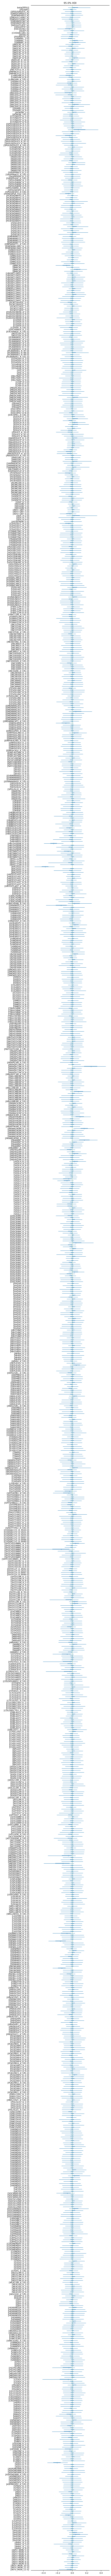

In [14]:
az.plot_forest(idata_sparse, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=False, rope=(0,0), textsize=8);
plt.tight_layout()

In [15]:
cutoff = 0.001
np.abs(summary['mean']).sort_values(ascending=False)[:20].index.values

array(['beta[BALDIZZ_A_2.0]', 'beta[HRLOUDJOB_A_2.0]',
       'beta[PAIHDFC3M_A_3.0]', 'beta[ASEV_A_2.0]',
       'beta[SHTCVD19NM1_A_5.0]', 'beta[PAIAMNT_A_2.0]',
       'beta[PAIWKLM3M_A_2.0]', 'beta[DENDL12M_A_2.0]',
       'beta[EARINFECT_A_2.0]', 'beta[MEDDL12M_A_2.0]',
       'beta[PAYWORRY_A_3.0]', 'beta[SPOUSEDUCP_A_5.0]',
       'beta[PAIAFFM3M_A_2.0]', 'beta[CFSEV_A_2.0]',
       'beta[PAIULMB3M_A_3.0]', 'beta[EMDSUPER_A_2.0]',
       'beta[DENNG12M_A_2.0]', 'beta[HYSTEV2_A_2.0]',
       'beta[BMICAT_A_2.0]', 'beta[MEDNG12M_A_2.0]'], dtype=object)

In [16]:
# extract top 20 features but drop duplicates
important = np.abs(summary['mean']).sort_values(ascending=False)[:20].index.values
important_feats = [re.search('\[(.+)_\d+\.0\]',idx).group(1) for idx in important]
# # preserve order
important_feats = list(dict.fromkeys(important_feats)) 
print(important_feats)

pattern = '|'.join(important_feats)
# # filter to keep only relevant features
X_train_new = X_train.filter(regex=pattern)
X_test_new = X_test.filter(regex=pattern)

['BALDIZZ_A', 'HRLOUDJOB_A', 'PAIHDFC3M_A', 'ASEV_A', 'SHTCVD19NM1_A', 'PAIAMNT_A', 'PAIWKLM3M_A', 'DENDL12M_A', 'EARINFECT_A', 'MEDDL12M_A', 'PAYWORRY_A', 'SPOUSEDUCP_A', 'PAIAFFM3M_A', 'CFSEV_A', 'PAIULMB3M_A', 'EMDSUPER_A', 'DENNG12M_A', 'HYSTEV2_A', 'BMICAT_A', 'MEDNG12M_A']


In [17]:
# summary.to_csv("feature_selection_results_2chains_v2.csv", index=True)

In [18]:
print(summary[summary['hdi_2.5%']>0].index)
summary[summary['hdi_2.5%']>0]

Index(['beta[PAIWKLM3M_A_2.0]'], dtype='object')


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[PAIWKLM3M_A_2.0],0.166,0.074,0.014,0.302,0.003,0.002,686.0,353.0,1.0


In [19]:
print(summary[summary['hdi_97.5%']<0].index)
summary[summary['hdi_97.5%']<0]

Index(['beta[HRLOUDJOB_A_2.0]', 'beta[BALDIZZ_A_2.0]', 'beta[ASEV_A_2.0]'], dtype='object')


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[HRLOUDJOB_A_2.0],-0.258,0.069,-0.391,-0.124,0.002,0.001,1281.0,570.0,1.0
beta[BALDIZZ_A_2.0],-0.376,0.072,-0.523,-0.244,0.002,0.002,1051.0,721.0,1.0
beta[ASEV_A_2.0],-0.209,0.074,-0.345,-0.064,0.002,0.002,1179.0,492.0,1.0


In [20]:
print(summary[summary['mean']>0.1].index)
summary[summary['mean']>0.1]

Index(['beta[SPOUSEDUCP_A_5.0]', 'beta[PAIHDFC3M_A_3.0]',
       'beta[PAIAFFM3M_A_2.0]', 'beta[PAIWKLM3M_A_2.0]',
       'beta[PAIAMNT_A_2.0]'],
      dtype='object')


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[SPOUSEDUCP_A_5.0],0.114,0.117,-0.060,0.360,0.004,0.003,561.0,806.0,1.00
beta[PAIHDFC3M_A_3.0],0.252,0.132,-0.001,0.464,0.014,0.010,90.0,17.0,1.02
beta[PAIAFFM3M_A_2.0],0.109,0.080,-0.017,0.257,0.004,0.003,368.0,632.0,1.00
beta[PAIWKLM3M_A_2.0],0.166,0.074,0.014,0.302,0.003,0.002,686.0,353.0,1.00
beta[PAIAMNT_A_2.0],0.171,0.103,-0.010,0.349,0.005,0.004,349.0,220.0,1.01


In [21]:
print(summary[summary['mean']<-0.1].index)
summary[summary['mean']<-0.1]

Index(['beta[HRLOUDJOB_A_2.0]', 'beta[BALDIZZ_A_2.0]', 'beta[EARINFECT_A_2.0]',
       'beta[SHTCVD19NM1_A_5.0]', 'beta[MEDDL12M_A_2.0]',
       'beta[DENDL12M_A_2.0]', 'beta[PAYWORRY_A_3.0]', 'beta[CFSEV_A_2.0]',
       'beta[ASEV_A_2.0]'],
      dtype='object')


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta[HRLOUDJOB_A_2.0],-0.258,0.069,-0.391,-0.124,0.002,0.001,1281.0,570.0,1.00
beta[BALDIZZ_A_2.0],-0.376,0.072,-0.523,-0.244,0.002,0.002,1051.0,721.0,1.00
beta[EARINFECT_A_2.0],-0.159,0.106,-0.363,0.015,0.004,0.003,702.0,452.0,1.00
beta[SHTCVD19NM1_A_5.0],-0.175,0.154,-0.493,0.031,0.006,0.005,420.0,763.0,1.01
beta[MEDDL12M_A_2.0],-0.146,0.123,-0.395,0.022,0.009,0.006,154.0,453.0,1.02
beta[DENDL12M_A_2.0],-0.164,0.096,-0.330,0.015,0.004,0.003,556.0,327.0,1.00
beta[PAYWORRY_A_3.0],-0.143,0.074,-0.271,0.002,0.003,0.002,594.0,247.0,1.00
beta[CFSEV_A_2.0],-0.108,0.135,-0.412,0.057,0.005,0.004,551.0,816.0,1.01
beta[ASEV_A_2.0],-0.209,0.074,-0.345,-0.064,0.002,0.002,1179.0,492.0,1.00
